In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
nEvents_list = np.logspace(8,13,6,dtype=int) # muons and electrons
nEvents = 1761393507.2305827*100*10
nEvents_dict = {"IC":nEvents/100,
                "KM3":nEvents,
                "PONE":nEvents}
nTrials = int(1e4)
highest_mode = 5
nBins = int(2**highest_mode)+1
t_bins = np.linspace(0,1,nBins+1)
t_bin_centers = (t_bins[1:] + t_bins[:-1])/2

from global_variables import *
from lv import *

from scipy.interpolate import interp1d
from scipy.stats import norm

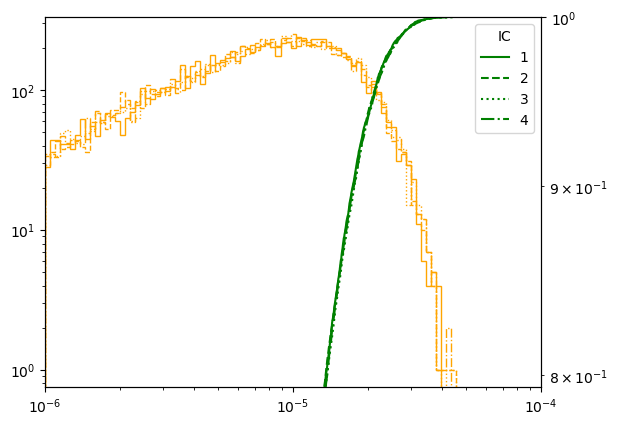

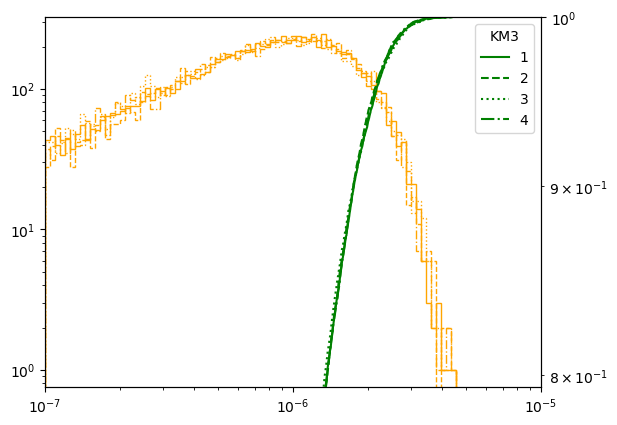

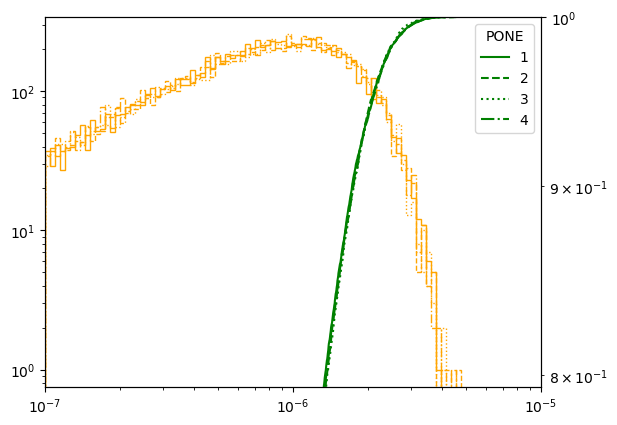

In [3]:
amplitudes = {}
quantile_points = np.logspace(-0.1,0,nTrials)
sensitivity_quantiles = [1-((1-norm.cdf(n))*2) for n in [1,2,3,5]]
sensitivity_quantiles += [0.9]
exp_sensitivities = {}
amplitude_bins = np.logspace(-6,-4,100)
for exp,nEvents in nEvents_dict.items():
    amplitude_bins = np.logspace(-6,-4,100)
    if exp!="IC": amplitude_bins /= 10
    amps = np.empty((nTrials,nBins))
    poisson_throws = np.random.poisson(nEvents/(nBins),(nTrials,nBins))
    for nT,n in enumerate(poisson_throws):
        fft = np.abs(np.real(np.fft.fft(n)))
        amps[nT][0] = fft[0]/nBins
        amps[nT][1:] = 2*fft[1:]/nBins
        amps[nT] /= amps[nT][0]
    amplitudes[exp] = amps
    
    fig = plt.figure()
    ax1 = plt.gca()
    ax2 = plt.gca().twinx()
    for mode,ls in zip([1,2,3,4],["-","--",":","-."]):
        ax1.hist(amps[:,mode],color="orange",bins=amplitude_bins,ls=ls,histtype="step")
        
        quantiles = np.quantile(amps[:,mode],quantile_points)
        ax2.plot(quantiles,quantile_points,color="green",ls=ls,label=mode)
        exp_sens = np.quantile(amps[:,mode],sensitivity_quantiles)
        exp_sensitivities[(exp,mode)] = {quant:sens for quant,sens in zip(sensitivity_quantiles,exp_sens)}
    ax1.set_xscale("log")
    ax2.set_xscale("log")
    ax1.set_xlim(amplitude_bins[0],amplitude_bins[-1])
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax2.set_ylim(quantile_points[0],quantile_points[-1])
    plt.legend(title=exp)
    plt.show()
    plt.close(fig)

## but how does amplitude correspond to PSD?

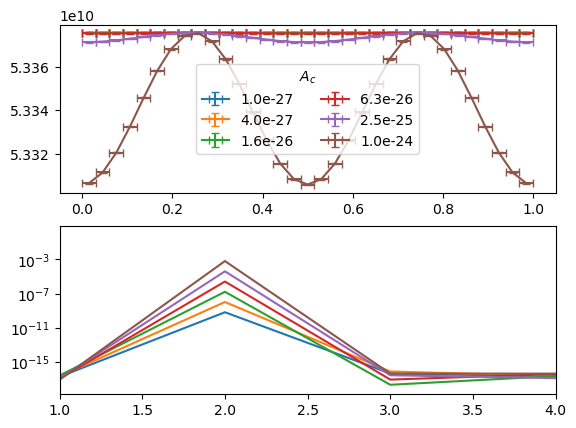

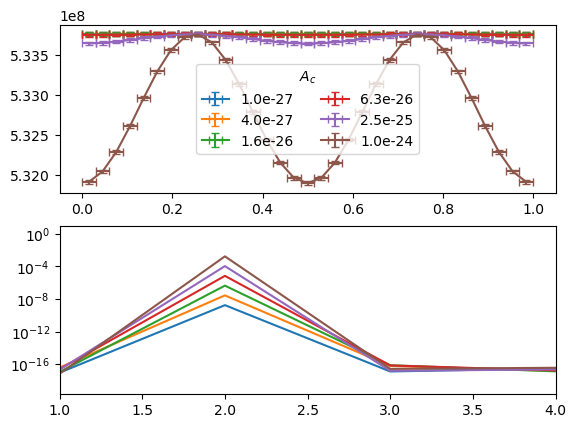

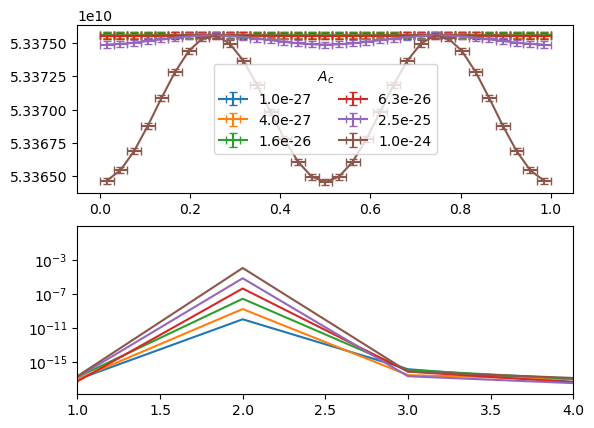

In [4]:
Ac_list = np.logspace(-27,-24,6)
mode2_amps = {}
for exp in experiment_list:
    amp = np.empty(int(nBins/2-1))
    fig,ax = plt.subplots(2,1)
    mode2_amps[exp] = []
    for Ac in Ac_list:
        events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],t_bin_centers,Ac=Ac)
        fft = np.abs(np.abs(np.fft.fft(events)))[:int(nBins/2)-1]
        amp[0] = fft[0]/nBins
        amp[1:] = 2*fft[1:]/nBins
        amp/= amp[0]
        mode2_amps[exp].append(amp[2])
        ax[0].errorbar(t_bin_centers,events,xerr=(t_bins[1]-t_bins[0])/2,yerr=np.sqrt(events),capsize=3,label="%1.1e"%Ac)
        ax[1].plot(amp)
    ax[0].legend(ncol=2,title=r"$A_c$")
    #ax[0].semilogy()
    ax[1].semilogy()
    #ax[1].set_ylim(1e-6,1e-2)
    ax[1].set_xlim(1,4)
    plt.show()
    plt.close(fig)



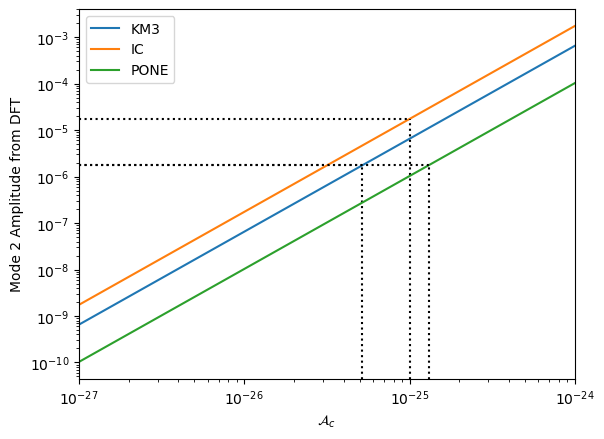

In [5]:
Ac_upper_limit = {}
for exp in experiment_list:
    Ac_interp = interp1d(np.log10(mode2_amps[exp]),np.log10(Ac_list))
    amp_upper_limit = exp_sensitivities[(exp,2)][0.9]
    Ac_upper_limit[exp] = 10**Ac_interp(np.log10(amp_upper_limit))
    plt.plot(Ac_list,mode2_amps[exp],label=exp)
    plt.plot([Ac_list[0],Ac_upper_limit[exp]],
             [amp_upper_limit,amp_upper_limit],
             color="black",ls=":")
    plt.plot([Ac_upper_limit[exp],Ac_upper_limit[exp]],
             [0,amp_upper_limit],
             color="black",ls=":")
plt.xlabel(r"$\mathcal{A}_c$")
plt.ylabel("Mode 2 Amplitude from DFT")
plt.loglog()
plt.legend()
plt.xlim(Ac_list[0],Ac_list[-1])
plt.show()

# Now in terms of the bare LIV coefficients

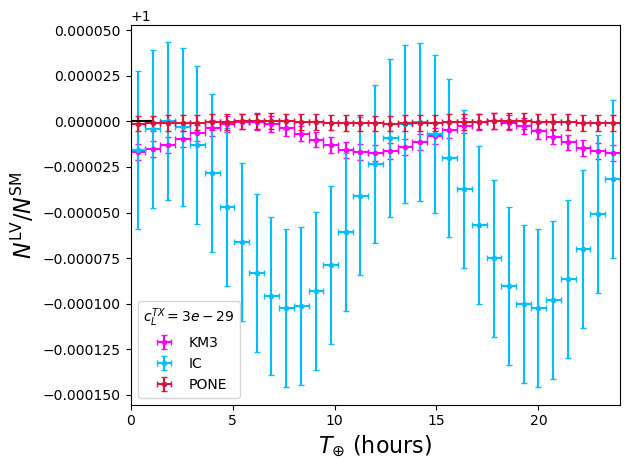

In [13]:
aL_vec = np.zeros(4)
cL_vec = np.zeros((4,4))
cL_vec[0,1] = 3e-29 # for example
LVsv = LV_sidreal_variations(aL_vec,cL_vec)
for exp in experiment_list:
    C,As,Ac,Bs,Bc = LVsv.get_coefficients(exp)
    nominal = (nEvents_dict[exp]/nBins)
    events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],
                                                t_bin_centers,
                                                C=C,
                                                Ac=Ac,As=As,
                                                Bc=Bc,Bs=Bs)
    plt.errorbar(t_bin_centers*24,events/nominal,xerr=24*(t_bins[1]-t_bins[0])/2,yerr=np.sqrt(events)/nominal,
                 color=color_list[exp],capsize=2,label=exp,fmt=".")
plt.plot([0,1],[1,1],color="black")
plt.legend(title=r"$c_L^{TX} = %0.0e$"%cL_vec[0,1])
plt.xlim(0,24)
#plt.semilogy()
plt.xlabel(r"$T_{\oplus}$ (hours)",fontsize=16)
plt.ylabel(r"$N^{\rm LV} / N^{\rm SM}$",fontsize=16)
plt.tight_layout()
plt.savefig("figures/LV_sidereal.pdf",dpi=100)
plt.show()

In [14]:
aL_range = np.logspace(-26.5,-22.9,20)
cL_range = np.logspace(-30.5,-26.5,20)
aL_amps = {}
cL_amps = {}
for aL in aL_range:
    aL_vec = np.zeros(4)
    for pos in range(4):
        aL_vec[pos] = aL
        LVsv = LV_sidreal_variations(aL_vec,np.zeros((4,4)))
        for exp in experiment_list:
            C,As,Ac,Bs,Bc = LVsv.get_coefficients(exp)
            events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],
                                              t_bin_centers,
                                              C=C,
                                              Ac=Ac,As=As,
                                              Bc=Bc,Bs=Bs)
            fft = np.abs(np.real(np.fft.fft(events)))
            amps = np.zeros(nBins)
            amps[0] = fft[0]/nBins
            amps[1:] = 2*fft[1:]/nBins
            amps /= amps[0]
            aL_amps[(exp,pos,aL)] = amps
for cL in cL_range:
    cL_vec = np.zeros((4,4))
    for pos1 in range(4):
        for pos2 in range(4):
            cL_vec[pos1,pos2] = cL
            LVsv = LV_sidreal_variations(np.zeros(4),cL_vec)
            for exp in experiment_list:
                C,As,Ac,Bs,Bc = LVsv.get_coefficients(exp)
                events = (nEvents_dict[exp]/nBins)*osc_prob(baseline_list[exp],
                                                  t_bin_centers,
                                                  C=C,
                                                  Ac=Ac,As=As,
                                                  Bc=Bc,Bs=Bs)
                fft = np.abs(np.real(np.fft.fft(events)))
                amps = np.zeros(nBins)
                amps[0] = fft[0]/nBins
                amps[1:] = 2*fft[1:]/nBins
                amps /= amps[0]
                cL_amps[(exp,pos1,pos2,cL)] = amps


            
            #nominal = (nEvents_dict[exp]/nBins)
        
    #     plt.errorbar(t_bin_centers,events/nominal - 1,xerr=(t_bins[1]-t_bins[0])/2,yerr=np.sqrt(events)/nominal,capsize=3,label=exp,fmt='.')
    # plt.plot([0,1],[0,0],color="grey",ls="-")
    # plt.ylabel("(LV - SM)/SM")
    # plt.xlabel(r"Local Sidereal Phase")
    # plt.legend(title=r"$\mathcal{A}_c/(10^{-21}) = %1.1f$"%(Ac/1e-21))
    # plt.xlim(0,1)
    # plt.show()

Warning! We are not in the short baseline regime. perturbation term reaches 1.3
Warning! We are not in the short baseline regime. perturbation term reaches 1.2
Warning! We are not in the short baseline regime. perturbation term reaches 2.1
Warning! We are not in the short baseline regime. perturbation term reaches 3.0
Warning! We are not in the short baseline regime. perturbation term reaches 2.8
Warning! We are not in the short baseline regime. perturbation term reaches 1.0
Warning! We are not in the short baseline regime. perturbation term reaches 1.4
Warning! We are not in the short baseline regime. perturbation term reaches 1.9
Warning! We are not in the short baseline regime. perturbation term reaches 1.9
Warning! We are not in the short baseline regime. perturbation term reaches 1.9
Warning! We are not in the short baseline regime. perturbation term reaches 1.8
Warning! We are not in the short baseline regime. perturbation term reaches 2.7
Warning! We are not in the short baselin

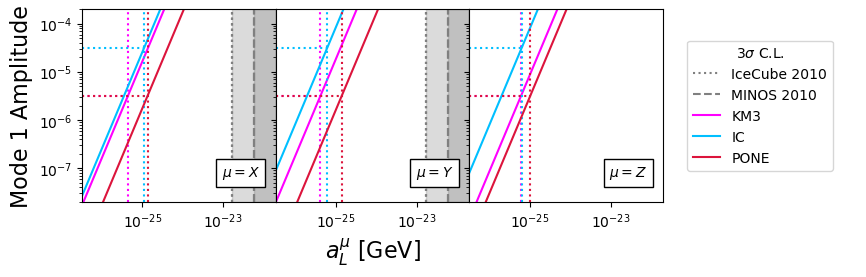

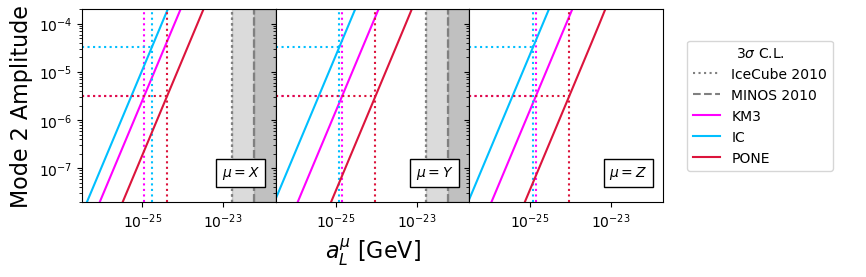

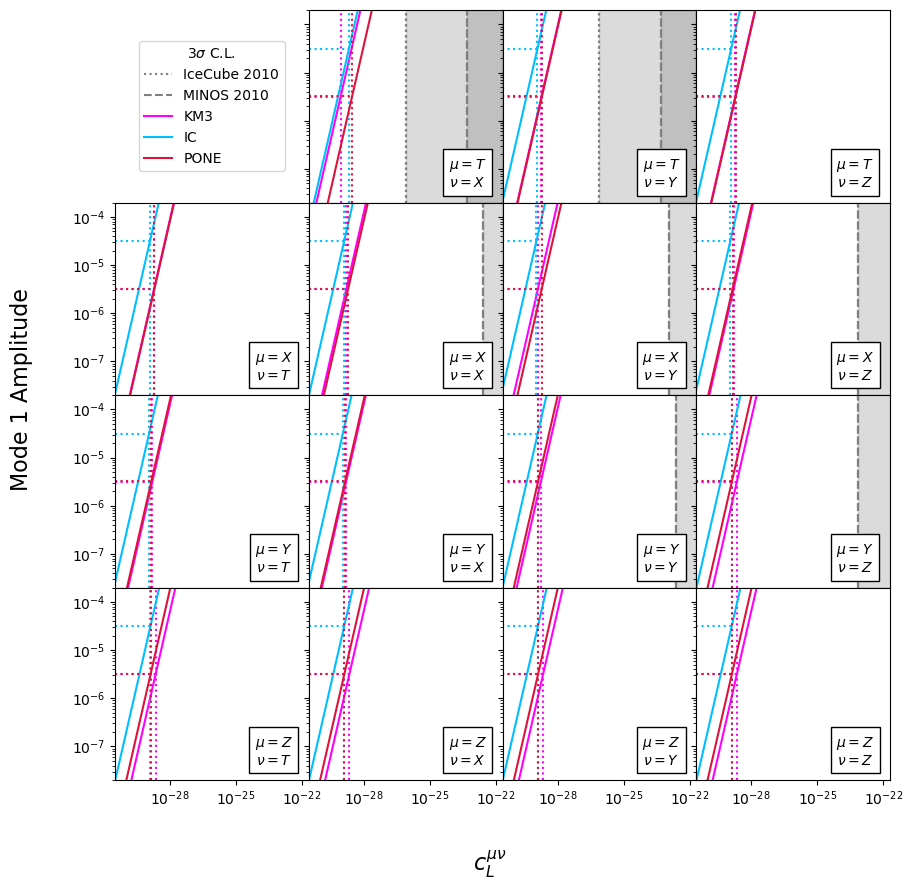

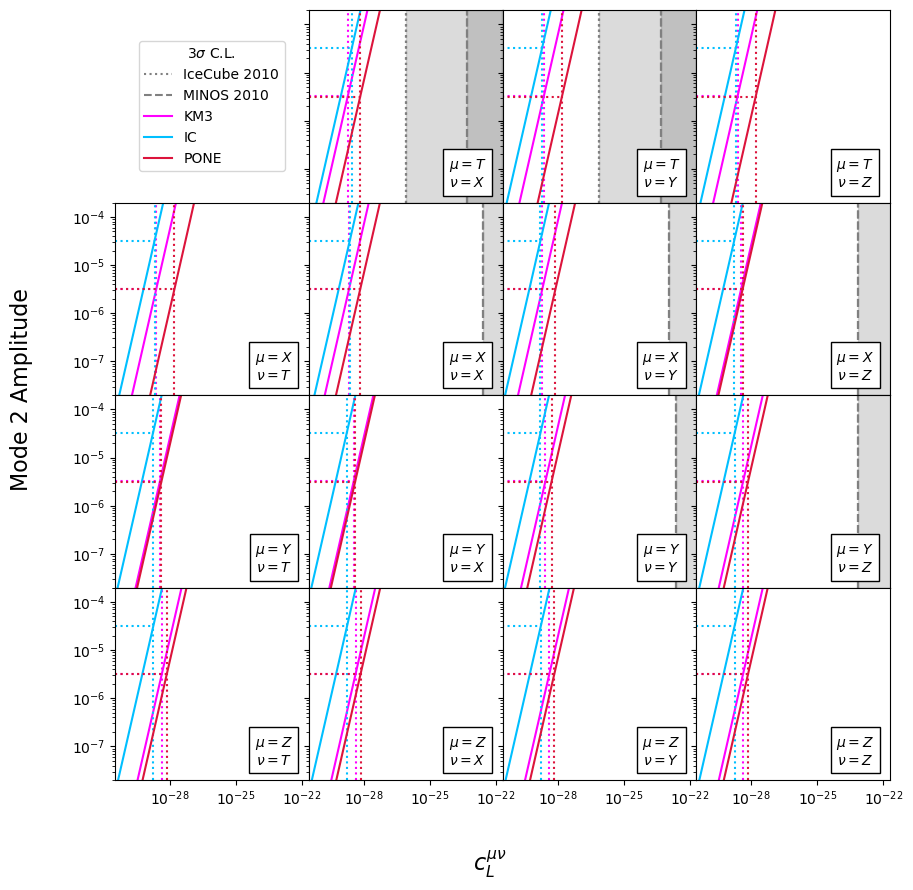

In [27]:
def plot_upper_limit(amp_uppper_limit,
                     coeff_points,
                     amp_points,
                     ax,color):
    coeff_interp = interp1d(np.log10(amp_points),np.log10(coeff_points))
    coeff_upper_limit = 10**coeff_interp(np.log10(amp_upper_limit))
    ax.plot([coeff_points[0],coeff_upper_limit],
            [amp_upper_limit,amp_upper_limit],
             color=color,ls=":")
    ax.axvline(coeff_upper_limit,color=color,ls=":")
    return coeff_upper_limit

sens_level = sensitivity_quantiles[2] # 3 sigma
lorentz_index = {0:"T",
                 1:"X",
                 2:"Y",
                 3:"Z"}

# IceCube atmospherics: https://arxiv.org/abs/1010.4096
IC_upper_limit_aL = {1:1.7e-23,
                     2:1.7e-23,}

IC_upper_limit_cL = {(0,1):7.9e-27,
                     (0,2):7.9e-27}

# MINOS far detector: https://arxiv.org/pdf/1007.2791
MINOS_upper_limit_aL = {1:5.9e-23,
                        2:6.1e-23,}

MINOS_upper_limit_cL = {(0,1):0.5e-23,
                        (1,1):2.5e-23,
                        (1,2):1.2e-23,
                        (1,3):0.7e-23,
                        (0,2):0.5e-23,
                        (2,2):2.4e-23,
                        (2,3):0.7e-23}

aL_max = 2e-22
cL_max = 2e-22
amp_min = 2e-8
amp_max = 2e-4

for mode in [1,2]:
    fig,ax = plt.subplots(1,4,sharey=True,figsize=(10,2.5))
    plt.subplots_adjust(wspace=0)
    ax[-1].axis("Off")
    ax[0].set_ylabel("Mode %d Amplitude"%mode,fontsize=16)
    ax[1].set_xlabel(r"$a_L^\mu$ [GeV]",fontsize=16)
    ax[-1].plot([],[],color="gray",ls=":",label="IceCube 2010")
    ax[-1].plot([],[],color="gray",ls="--",label="MINOS 2010")
    for exp in experiment_list:
        amp_upper_limit = exp_sensitivities[(exp,mode)][sens_level]
        ax[-1].plot([],[],color=color_list[exp],label=exp)
        for pos in [1,2,3]:
            amps_per_aL = [aL_amps[(exp,pos,aL)][mode] for aL in aL_range]
            ax[pos-1].plot(aL_range,amps_per_aL,color=color_list[exp])
            plot_upper_limit(amp_upper_limit,aL_range,amps_per_aL,ax[pos-1],color_list[exp])
            
            # IceCube limits
            if pos in IC_upper_limit_aL.keys():
                ax[pos-1].plot([IC_upper_limit_aL[pos],IC_upper_limit_aL[pos]],
                               [amp_min,amp_max],color="gray",ls=":")
                ax[pos-1].fill_betweenx([amp_min,amp_max],
                                        x1=IC_upper_limit_aL[pos],
                                        x2=aL_max,
                                        color="gray",alpha=0.1)
            # MINOS limits
            if pos in MINOS_upper_limit_aL.keys():
                ax[pos-1].plot([MINOS_upper_limit_aL[pos],MINOS_upper_limit_aL[pos]],
                               [amp_min,amp_max],color="gray",ls="--")
                ax[pos-1].fill_betweenx([amp_min,amp_max],
                                        x1=MINOS_upper_limit_aL[pos],
                                        x2=aL_max,
                                        color="gray",alpha=0.1)
                
            if exp=="IC":
                ax[pos-1].text(0.82,0.15,r"$\mu = %s$"%lorentz_index[pos],
                           horizontalalignment='center', verticalalignment='center', 
                           transform=ax[pos-1].transAxes,
                           bbox=dict(facecolor='white',edgecolor="black"))
                ax[pos-1].loglog()
                ax[pos-1].set_xlim(aL_range[0],aL_max)
                ax[pos-1].set_ylim(amp_min,amp_max)
    ax[-1].legend(title=r"$3\sigma$ C.L.",loc="center")
    #plt.tight_layout()
    plt.savefig("figures/LV_aL_mode%d.pdf"%mode,dpi=100,bbox_inches='tight')
    plt.show()




for mode in [1,2]:
    fig,ax = plt.subplots(4,4,sharey=True,sharex=True,figsize=(10,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    ax[0,0].axis("off")
    fig.supylabel("Mode %d Amplitude"%mode,fontsize=16)
    fig.supxlabel(r"$c_L^{\mu \nu}$",fontsize=16)
    ax[0,0].plot([],[],color="gray",ls=":",label="IceCube 2010")
    ax[0,0].plot([],[],color="gray",ls="--",label="MINOS 2010")
    for exp in experiment_list:
        amp_upper_limit = exp_sensitivities[(exp,mode)][sens_level]
        ax[0,0].plot([],[],color=color_list[exp],label=exp)
        for pos1 in range(4):
            for pos2 in range(4):
                if pos1==0 and pos2==0: continue
                amps_per_cL = [cL_amps[(exp,pos1,pos2,cL)][mode] for cL in cL_range]
                if (amps_per_cL[-1]/amps_per_cL[0] < 10): continue
                ax[pos1,pos2].plot(cL_range,amps_per_cL,color=color_list[exp])
                plot_upper_limit(amp_upper_limit,cL_range,amps_per_cL,ax[pos1,pos2],color_list[exp])

                # IceCube limits 
                if (pos1,pos2) in IC_upper_limit_cL.keys():
                    ax[(pos1,pos2)].plot([IC_upper_limit_cL[(pos1,pos2)],IC_upper_limit_cL[(pos1,pos2)]],
                                   [amp_min,amp_max],color="gray",ls=":")
                    ax[(pos1,pos2)].fill_betweenx([amp_min,amp_max],
                                            x1=IC_upper_limit_cL[(pos1,pos2)],
                                            x2=cL_max,
                                            color="gray",alpha=0.1)
                # MINOS limits 
                if (pos1,pos2) in MINOS_upper_limit_cL.keys():
                    ax[(pos1,pos2)].plot([MINOS_upper_limit_cL[(pos1,pos2)],MINOS_upper_limit_cL[(pos1,pos2)]],
                                   [amp_min,amp_max],color="gray",ls="--")
                    ax[(pos1,pos2)].fill_betweenx([amp_min,amp_max],
                                            x1=MINOS_upper_limit_cL[(pos1,pos2)],
                                            x2=cL_max,
                                            color="gray",alpha=0.1)
                    
                if exp=="IC":
                    ax[pos1,pos2].text(0.82,0.15,r"$\mu = %s$"%lorentz_index[pos1]+"\n"+r"$\nu = %s$"%lorentz_index[pos2],
                                       horizontalalignment='center', verticalalignment='center', 
                                       transform=ax[pos1,pos2].transAxes,
                                       bbox=dict(facecolor='white',edgecolor="black"))
                    ax[pos1,pos2].loglog()
                    ax[pos1,pos2].set_xlim(cL_range[0],cL_max)
                    ax[pos1,pos2].set_ylim(amp_min,amp_max)
    ax[0,0].legend(title=r"$3\sigma$ C.L.",loc="center")
    plt.savefig("figures/LV_cL_mode%d.pdf"%mode,dpi=100,bbox_inches='tight')
    plt.show()

# for pos1 in range(4):
#     for pos2 in range(4):
#         if pos1==0 and pos2==0: continue
#         for exp in experiment_list:
#             for mode,ls in zip([1,2,3,4],["-","--",":","-."]):
#                 if exp=="IC": plt.plot([],[],color="black",ls=ls,label="Mode %d"%mode)
#                 if mode==1: plt.plot([],[],color=color_list[exp],label=exp)
#                 plt.plot(cL_range,[cL_amps[(exp,pos1,pos2,cL)][mode] for cL in cL_range],color=color_list[exp],ls=ls)
#         plt.loglog()
#         plt.legend()
#         plt.title("%d,%d"%(pos1,pos2))
#         plt.show()